# ดึงข้อมูลฝนรายชั่วโมงทั้งประเทศไทย
* ดึงฝนรายชั่วโมงตามข้อมูลพิกัดใน csv
* พลอตแผนที่เพื่อตรวจสอบฝนทั้งประเทศในรายชั่วโมงที่ต้องการ กำหนดช่วงเวลาที่ต้องการได้
* พลอตแผนที่เพื่อตรวจสอบฝนทั้งประเทศในรายชั่วโมงที่ต้องการแบบ 4 แถว x 2 หลัก

In [13]:
'''
2024.09.22
โค้ดนี้พัฒนาโดย รองศาสตราจารย์ ดร. นัฐพล มหาวิค ภาควิชาทรัพยากรธรรมชาติและสิ่งแวดล้อม คณะเกษตรศาสตร์ฯ มหาวิทยาลัยนเรศวร 
ในงานวิจัย เรื่อง "การวิจัยและพัฒนาผลิตภัณฑ์โมเสคฝนประมาณค่าจากเรดาร์ตรวจอากาศในพื้นที่ระดับลุ่มน้ำของประเทศไทยด้วยเทคโนโลยีภูมิสารสนเทศรหัสเปิด"
สนับสนุนทุนวิจัยโดยสํานักงานการวิจัยแห่งชาติ (วช.)  แผนงานการวิจัยและนวัตกรรมแผนงานด้านการบริหารจัดการภัยพิบัติทางธรรมชาติ 
ประจำปีงบประมาณ 2566  ตามสัญญา เลขที่ N25A660467 ผู้นำโค้ดนี้ไปใช้หรือดัดแปลงควรอ้างอิงงานวิจัยชิ้นนี้ตามหลักเกณฑ์การอ้างอิงสากล
เรียนหลักการเรดาร์และภูมิสารสนเทศ ที่ https://www.youtube.com/@Nattapon_Mahavik/playlists
หนังสือเรดาร์ตรวจอากาศทางอุตุนิยมวิทยา สำนักพิมพ์จุฬาฯ : https://www.chulabook.com/education/144567
หนังสือออนไลน์เรดาร์ตรวจอากาศทางอุตุนิยมวิทยา สำนักพิมพ์จุฬาฯ : https://www.chulabook.com/education/205129
ติดต่อ nattaponm@nu.ac.th
'''

# ดึงข้อมูลฝนรายชั่วโมงทั้งประเทศไทย
import os
import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from dateutil import rrule
from pathlib import Path

# Constants
URL_SOURCE = 'https://tiservice.hii.or.th/opendata/data_catalog/hourly_rain/'
PATH_OUTPUT = './0Zprocessing_data/0hourly_rain_thai_mos/0Sontihn/1firstDownload/'
OUT_RAIN_HR_PATH = './0Zprocessing_data/0hourly_rain_thai_mos/0Sontihn/0Hourly/'
#STATIONS_FILE = '../1data/1GIS/0base_map_gis/GaugeInCPYBasin_wgs84.csv'
STATIONS_FILE = '../1data/3Gagues/station_metadata_haii_geographic.csv'
HII_STATIONS_URL = 'https://tiservice.hii.or.th/opendata/data_catalog/daily_rain/0station_metadata.csv'

def ensure_dir(directory):
    """Create directory if it doesn't exist."""
    Path(directory).mkdir(parents=True, exist_ok=True)

def get_rainfall_hii(df_filter, start, end):
    """Download rainfall data from HII for specified stations and date range."""
    date_start = datetime.strptime(start, '%Y-%m-%d')
    date_end = datetime.strptime(end, '%Y-%m-%d')
    
    for date in rrule.rrule(rrule.MONTHLY, dtstart=date_start, until=date_end):
        year, month = date.strftime('%Y'), date.strftime('%m')
        path = Path(f"{PATH_OUTPUT}{year}/{month}")
        ensure_dir(path)
        
        for code in df_filter['code']:
            url = f"{URL_SOURCE}{year}/{year}{month}/{code.strip()}.csv"
            response = requests.get(url)
            if response.status_code == 200:
                (path / f"{code.strip()}.csv").write_bytes(response.content)
                print(f"Downloaded: {year}/{month}/{code.strip()}")
            else:
                print(f"Failed: {year}/{month}/{code.strip()}")

def process_and_export_hourly_rainfall(start_date, end_date, df_filter):
    """Process and export hourly rainfall data for the specified date range."""
    ensure_dir(OUT_RAIN_HR_PATH)
    
    current_date = start_date
    while current_date <= end_date:
        year, month = current_date.strftime('%Y'), current_date.strftime('%m')
        daily_data = []
        
        # Read data for the current day from all stations
        for code in df_filter['code']:
            file_path = Path(f"{PATH_OUTPUT}{year}/{month}/{code.strip()}.csv")
            if file_path.exists():
                df = pd.read_csv(file_path)
                df['station'] = code.strip()
                daily_data.append(df[df['date'] == current_date.strftime('%Y-%m-%d')])
        
        if daily_data:
            daily_df = pd.concat(daily_data)
            daily_df['full_date'] = daily_df['date'] + '-' + daily_df['time']
            
            # Process and export data for each hour of the day
            for hour in range(24):
                hour_str = f"{hour:02d}:00"
                hour_data = daily_df[daily_df['time'] == hour_str]
                
                if not hour_data.empty:
                    df_rain_pl = hour_data.merge(df_filter, left_on='station', right_on='code')
                    df_cleaned = df_rain_pl[~df_rain_pl['rain'].isin(['-', -999.0])].dropna().reset_index(drop=True)
                    
                    if not df_cleaned.empty:
                        file_name = current_date.strftime('%Y%m%d') + f"{hour:02d}" + '.csv'
                        df_cleaned.to_csv(OUT_RAIN_HR_PATH + file_name, encoding='utf-8-sig', index=False)
                        print(f"Exported: {file_name}")
        
        current_date += timedelta(days=1)

def main():
    # Ensure output directories exist
    ensure_dir(PATH_OUTPUT)
    ensure_dir(OUT_RAIN_HR_PATH)

    # Load and prepare station data
    df_pl = pd.read_csv(STATIONS_FILE)
    df_hii = pd.read_csv(HII_STATIONS_URL)
    df_hii['code'] = df_hii['station_code'].str.strip()
    df_filter = df_hii[df_hii['code'].isin(df_pl['code'].str.strip())]
    
    # Set date range
    start = '2018-07-15'
    end = '2018-07-25'
    start_date = datetime.strptime(start, '%Y-%m-%d')
    end_date = datetime.strptime(end, '%Y-%m-%d')
    
    # Download rainfall data
    get_rainfall_hii(df_filter, start, end)
    
    # Process and export hourly rainfall data
    process_and_export_hourly_rainfall(start_date, end_date, df_filter)

if __name__ == "__main__":
    main()

Downloaded: 2018/07/ABRT
Downloaded: 2018/07/ACRU
Failed: 2018/07/ATG011
Failed: 2018/07/ATG021
Failed: 2018/07/ATG031
Failed: 2018/07/ATG032
Failed: 2018/07/ATG042
Failed: 2018/07/ATG051
Failed: 2018/07/ATG052
Failed: 2018/07/ATG072
Failed: 2018/07/ATG081
Failed: 2018/07/ATG082
Failed: 2018/07/ATG091
Failed: 2018/07/ATG092
Failed: 2018/07/ATG101
Failed: 2018/07/ATG111
Failed: 2018/07/ATG112
Failed: 2018/07/ATG121
Failed: 2018/07/ATG122
Failed: 2018/07/ATG131
Failed: 2018/07/ATG132
Failed: 2018/07/ATG141
Failed: 2018/07/ATG142
Failed: 2018/07/ATG151
Failed: 2018/07/ATG152
Failed: 2018/07/ATG161
Failed: 2018/07/ATG162
Failed: 2018/07/ATG171
Failed: 2018/07/ATG181
Failed: 2018/07/ATG182
Downloaded: 2018/07/BAKI
Downloaded: 2018/07/BARI
Downloaded: 2018/07/BBHN
Downloaded: 2018/07/BBON
Downloaded: 2018/07/BBUA
Downloaded: 2018/07/BBWN
Downloaded: 2018/07/BCNG
Downloaded: 2018/07/BDAR
Downloaded: 2018/07/BDCP
Downloaded: 2018/07/BDGN
Downloaded: 2018/07/BDLH
Downloaded: 2018/07/BDMG
Downlo

# พลอตเช็คผลแบบเลือกได้หลายชั่วโมง

Created directory: ./0Zprocessing_data/0hourly_rain_thai_mos/0Sontihn/0maps
Processing file: ./0Zprocessing_data/0hourly_rain_thai_mos/0Sontihn/0Hourly\2018071721.csv


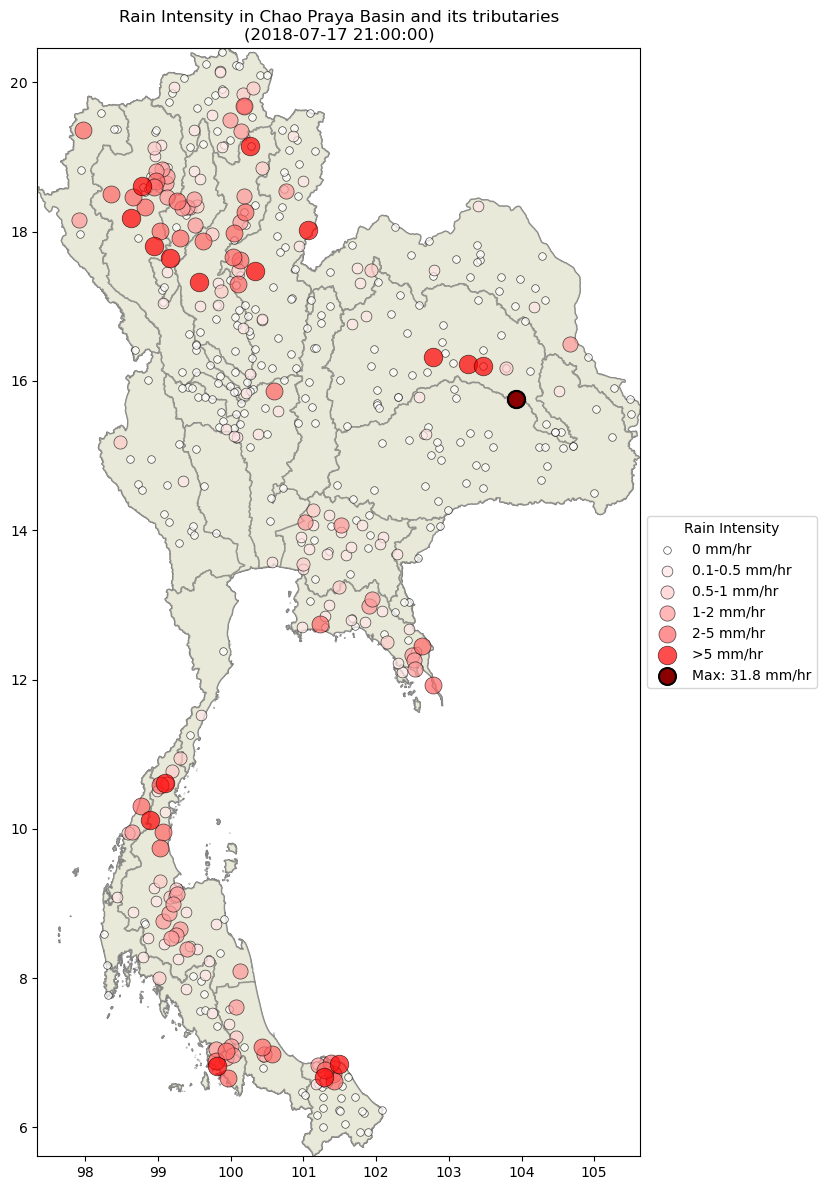

Saved map to: ./0Zprocessing_data/0hourly_rain_thai_mos/0Sontihn/0maps\2018071721.jpg
Total number of stations: 510
Stations with rainfall 0 mm/hr: 307
Stations with rainfall 0.1-0.5 mm/hr: 85
Stations with rainfall 0.5-1 mm/hr: 27
Stations with rainfall 1-2 mm/hr: 41
Stations with rainfall 2-5 mm/hr: 33
Stations with rainfall >5 mm/hr: 17
Station with max rainfall: อบต.หนองหมื่นถ่าน (31.8 mm/hr)
Processing file: ./0Zprocessing_data/0hourly_rain_thai_mos/0Sontihn/0Hourly\2018071722.csv


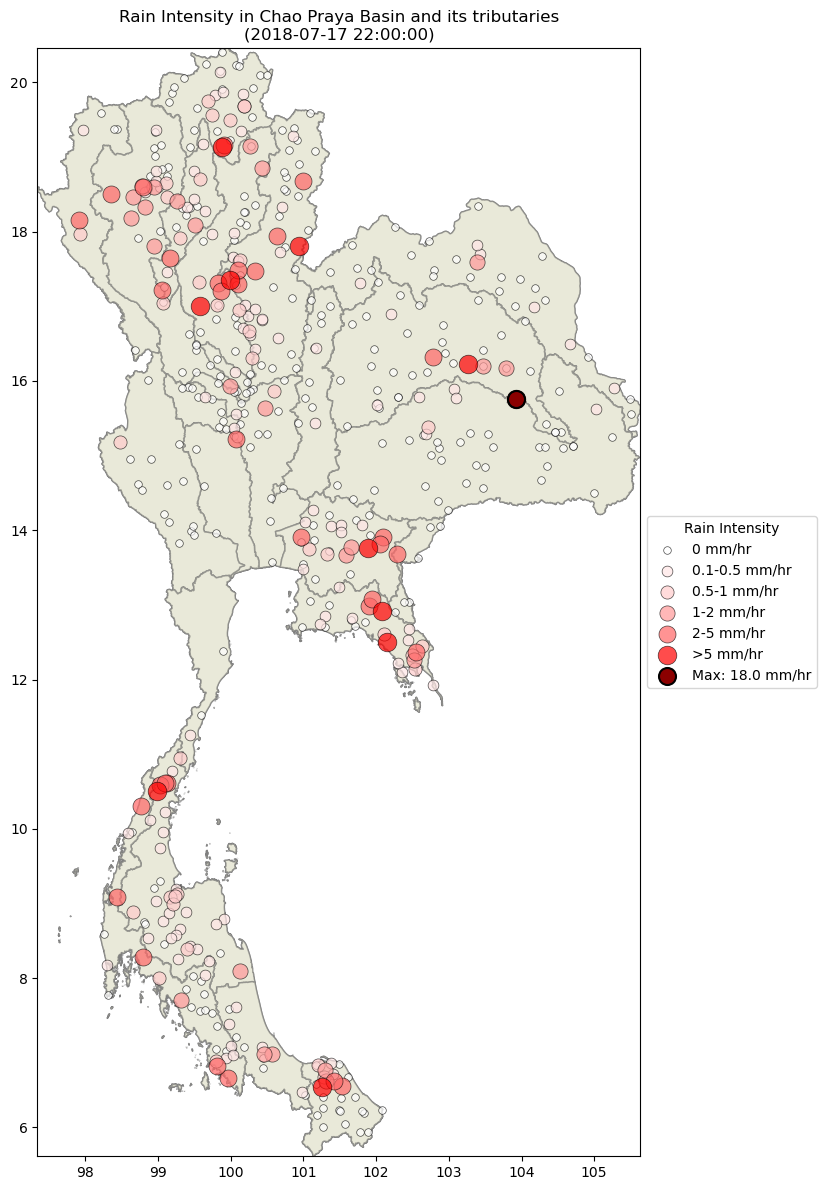

Saved map to: ./0Zprocessing_data/0hourly_rain_thai_mos/0Sontihn/0maps\2018071722.jpg
Total number of stations: 508
Stations with rainfall 0 mm/hr: 303
Stations with rainfall 0.1-0.5 mm/hr: 101
Stations with rainfall 0.5-1 mm/hr: 37
Stations with rainfall 1-2 mm/hr: 24
Stations with rainfall 2-5 mm/hr: 32
Stations with rainfall >5 mm/hr: 11
Station with max rainfall: อบต.หนองหมื่นถ่าน (18.0 mm/hr)


In [17]:
# พลอตเช็คผลแบบเลือกได้หลายชั่วโมง
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import os

def load_geographic_data(basin_file, all_basin_file):
    """Load and return the geographic data for the basins."""
    basin_map = gpd.read_file(basin_file, encoding="UTF-8")
    all_basin = gpd.read_file(all_basin_file)
    return basin_map, all_basin

def load_rainfall_data(file_path):
    """Load and process the rainfall data from a CSV file."""
    df = pd.read_csv(file_path)
    geo_df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
    geo_df.set_crs(epsg=4326, inplace=True)
    return geo_df

def ensure_dir_exists(directory):
    """Create the directory if it doesn't exist."""
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Created directory: {directory}")

def create_rainfall_map(basin_map, all_basin, geo_df, output_path, timestamp):
    """Create and save a rainfall intensity map."""
    ensure_dir_exists(output_path)
    
    fig, ax = plt.subplots(figsize=(12, 12))

    # Plot the basins
    basin_map.to_crs(epsg=4326).plot(ax=ax, color='lightgrey', edgecolor='grey', linewidth=1)
    all_basin.to_crs(epsg=4326).plot(ax=ax, color='lightyellow', edgecolor='grey', linewidth=1, alpha=0.5)

    # Define rain intensity classes
    rain_classes = [0, 0.1, 0.5, 1, 2, 5, np.inf]
    colors = ['#FFFFFF', '#FFE6E6', '#FFCCCC', '#FF9999', '#FF6666', '#FF0000']
    labels = ['0', '0.1-0.5', '0.5-1', '1-2', '2-5', '>5']

    # Plot all stations
    for i, (lower, upper) in enumerate(zip(rain_classes[:-1], rain_classes[1:])):
        mask = (geo_df['rain'] >= lower) & (geo_df['rain'] < upper)
        ax.scatter(geo_df.loc[mask, 'longitude'], geo_df.loc[mask, 'latitude'], 
                   c=colors[i], s=(i+1)*30, alpha=0.7, edgecolor='black', linewidth=0.5,
                   label=f'{labels[i]} mm/hr')

    # Highlight the station with the highest rainfall
    max_rain_station = geo_df.loc[geo_df['rain'].idxmax()]
    ax.scatter(max_rain_station['longitude'], max_rain_station['latitude'], 
               c='darkred', s=150, alpha=1, edgecolor='black', linewidth=1.5,
               label=f'Max: {max_rain_station["rain"]:.1f} mm/hr')

    # Set the extent to focus on Chao Praya basin
    ax.set_xlim(all_basin.total_bounds[0], all_basin.total_bounds[2])
    ax.set_ylim(all_basin.total_bounds[1], all_basin.total_bounds[3])

    # Add legend and title
    ax.legend(title='Rain Intensity', loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_title(f'Rain Intensity in Chao Praya Basin and its tributaries\n({timestamp})')

    plt.tight_layout()
    output_file = os.path.join(output_path, f'{timestamp.strftime("%Y%m%d%H")}.jpg')
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved map to: {output_file}")

def print_statistics(geo_df):
    """Print statistics about the rainfall data."""
    rain_classes = [0, 0.1, 0.5, 1, 2, 5, np.inf]
    labels = ['0', '0.1-0.5', '0.5-1', '1-2', '2-5', '>5']

    print(f"Total number of stations: {len(geo_df)}")
    for i, (lower, upper) in enumerate(zip(rain_classes[:-1], rain_classes[1:])):
        count = ((geo_df['rain'] >= lower) & (geo_df['rain'] < upper)).sum()
        print(f"Stations with rainfall {labels[i]} mm/hr: {count}")

    max_rain_station = geo_df.loc[geo_df['rain'].idxmax()]
    print(f"Station with max rainfall: {max_rain_station['station_name']} ({max_rain_station['rain']:.1f} mm/hr)")

def process_rainfall_data(start_time, end_time, data_dir, output_dir):
    """Process rainfall data for a range of hours and create maps."""
    ensure_dir_exists(output_dir)
    
    basin_map, all_basin = load_geographic_data(
        '../1data/1GIS/0base_map_gis/MainBasin_ONWR_Law_WGS84Geo.shp',
        '../1data/1GIS/0base_map_gis/MainBasin_ONWR_Law_WGS84Geo.shp'
    )

    current_time = start_time
    while current_time <= end_time:
        file_name = f"{current_time.strftime('%Y%m%d%H')}.csv"
        file_path = os.path.join(data_dir, file_name)
        
        if os.path.exists(file_path):
            print(f"Processing file: {file_path}")
            geo_df = load_rainfall_data(file_path)
            create_rainfall_map(basin_map, all_basin, geo_df, output_dir, current_time)
            print_statistics(geo_df)
        else:
            print(f"File not found: {file_path}")

        current_time += timedelta(hours=1)

# Example usage
if __name__ == "__main__":
    start_time = datetime(2018, 7, 17, 21)
    end_time = datetime(2018, 7, 17, 22)
    data_dir = './0Zprocessing_data/0hourly_rain_thai_mos/0Sontihn/0Hourly'
    output_dir = './0Zprocessing_data/0hourly_rain_thai_mos/0Sontihn/0maps'

    process_rainfall_data(start_time, end_time, data_dir, output_dir)

# พลอตฝนรายชั่วโมง แบบให้เวลาแรกไป แล้วพลอตอีก 7 ชั่วโมง แบบ 4 x 2

Processing file: ./0Zprocessing_data/0hourly_rain_thai_mos/0Sontihn/0Hourly\2018071721.csv

Statistics for 2018-07-17 21:00:00:
Total number of stations: 510
Stations with rainfall 0 mm/hr: 307
Stations with rainfall 0.1-0.5 mm/hr: 85
Stations with rainfall 0.5-1 mm/hr: 27
Stations with rainfall 1-2 mm/hr: 41
Stations with rainfall 2-5 mm/hr: 33
Stations with rainfall >5 mm/hr: 17
Station with max rainfall: อบต.หนองหมื่นถ่าน (31.8 mm/hr)
Processing file: ./0Zprocessing_data/0hourly_rain_thai_mos/0Sontihn/0Hourly\2018071722.csv

Statistics for 2018-07-17 22:00:00:
Total number of stations: 508
Stations with rainfall 0 mm/hr: 303
Stations with rainfall 0.1-0.5 mm/hr: 101
Stations with rainfall 0.5-1 mm/hr: 37
Stations with rainfall 1-2 mm/hr: 24
Stations with rainfall 2-5 mm/hr: 32
Stations with rainfall >5 mm/hr: 11
Station with max rainfall: อบต.หนองหมื่นถ่าน (18.0 mm/hr)
Processing file: ./0Zprocessing_data/0hourly_rain_thai_mos/0Sontihn/0Hourly\2018071723.csv

Statistics for 2018-07-

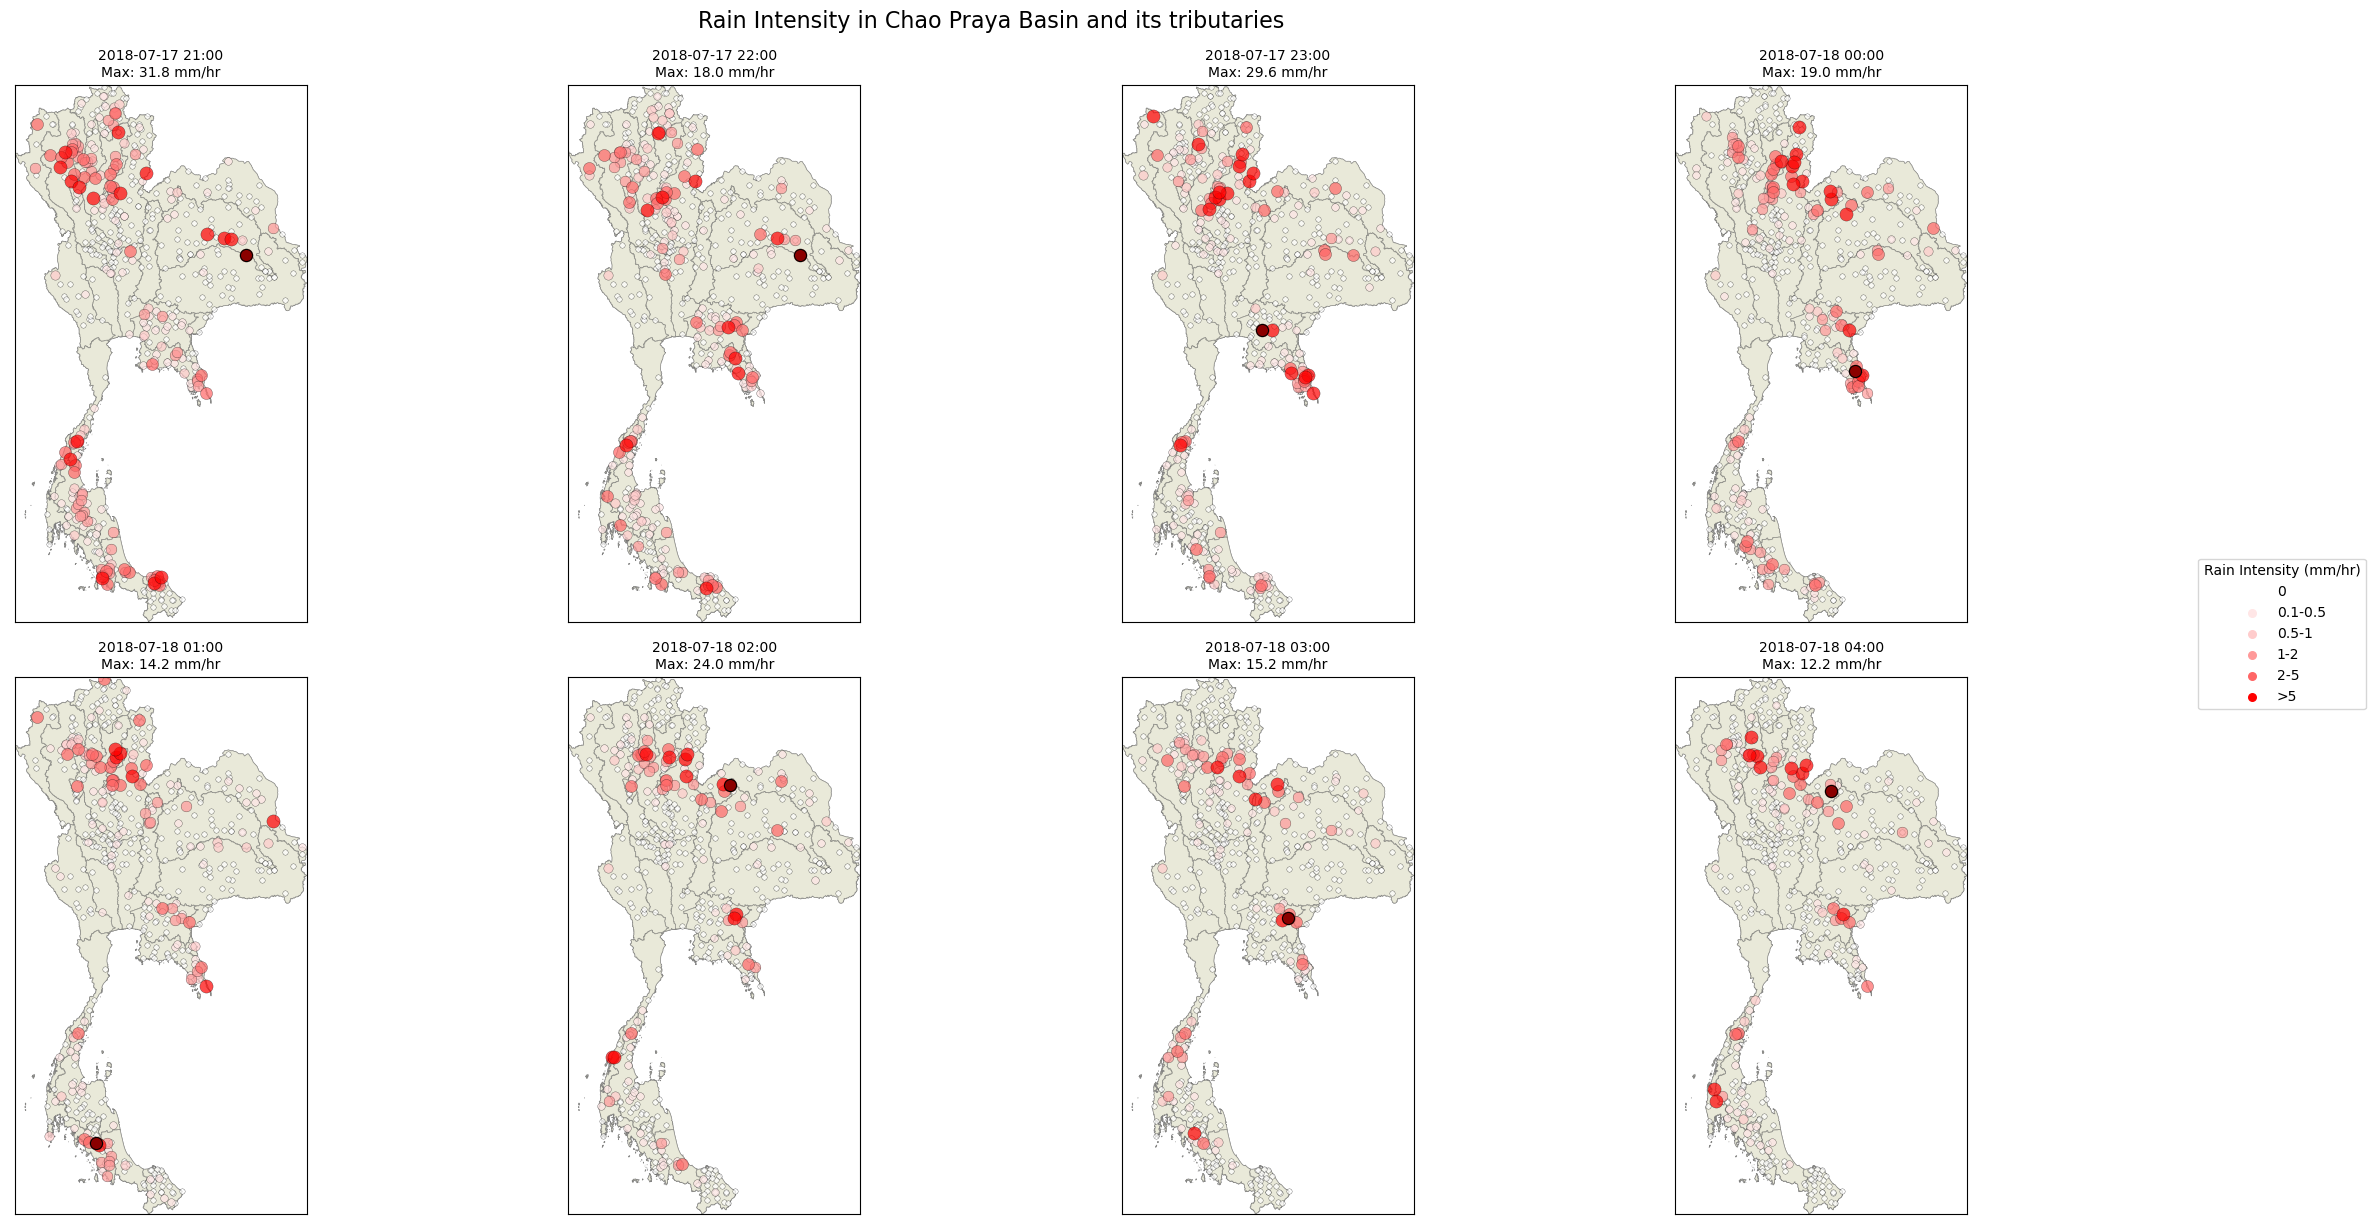

Saved map to: ./0Zprocessing_data/0hourly_rain_thai_mos/0Sontihn/0maps\2018071721_8hours.jpg


In [18]:
# พลอตฝนรายชั่วโมง แบบให้เวลาแรกไป แล้วพลอตอีก 7 ชั่วโมง แบบ 4 x 2
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import os

def load_geographic_data(basin_file, all_basin_file):
    """Load and return the geographic data for the basins."""
    basin_map = gpd.read_file(basin_file, encoding="UTF-8")
    all_basin = gpd.read_file(all_basin_file)
    return basin_map, all_basin

def load_rainfall_data(file_path):
    """Load and process the rainfall data from a CSV file."""
    df = pd.read_csv(file_path)
    geo_df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
    geo_df.set_crs(epsg=4326, inplace=True)
    return geo_df

def ensure_dir_exists(directory):
    """Create the directory if it doesn't exist."""
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Created directory: {directory}")

def create_rainfall_maps(basin_map, all_basin, data_frames, output_path, start_time):
    """Create and save rainfall intensity maps for 8 hours in a 4x2 grid."""
    ensure_dir_exists(output_path)
    
    fig, axes = plt.subplots(2, 4, figsize=(24, 12))
    axes = axes.flatten()

    # Define rain intensity classes
    rain_classes = [0, 0.1, 0.5, 1, 2, 5, np.inf]
    colors = ['#FFFFFF', '#FFE6E6', '#FFCCCC', '#FF9999', '#FF6666', '#FF0000']
    labels = ['0', '0.1-0.5', '0.5-1', '1-2', '2-5', '>5']

    for i, (timestamp, geo_df) in enumerate(data_frames.items()):
        ax = axes[i]

        # Plot the basins
        basin_map.to_crs(epsg=4326).plot(ax=ax, color='lightgrey', edgecolor='grey', linewidth=0.5)
        all_basin.to_crs(epsg=4326).plot(ax=ax, color='lightyellow', edgecolor='grey', linewidth=0.5, alpha=0.5)

        # Plot all stations
        for j, (lower, upper) in enumerate(zip(rain_classes[:-1], rain_classes[1:])):
            mask = (geo_df['rain'] >= lower) & (geo_df['rain'] < upper)
            ax.scatter(geo_df.loc[mask, 'longitude'], geo_df.loc[mask, 'latitude'], 
                       c=colors[j], s=(j+1)*15, alpha=0.7, edgecolor='black', linewidth=0.25)

        # Highlight the station with the highest rainfall
        max_rain_station = geo_df.loc[geo_df['rain'].idxmax()]
        ax.scatter(max_rain_station['longitude'], max_rain_station['latitude'], 
                   c='darkred', s=75, alpha=1, edgecolor='black', linewidth=0.75)

        # Set the extent to focus on Chao Praya basin
        ax.set_xlim(all_basin.total_bounds[0], all_basin.total_bounds[2])
        ax.set_ylim(all_basin.total_bounds[1], all_basin.total_bounds[3])

        # Add title for each subplot
        ax.set_title(f'{timestamp.strftime("%Y-%m-%d %H:%M")}\nMax: {max_rain_station["rain"]:.1f} mm/hr', fontsize=10)

        # Remove axis labels
        ax.set_xticks([])
        ax.set_yticks([])

    # Add a common legend
    legend_elements = [plt.scatter([], [], c=color, label=label, s=30) 
                       for color, label in zip(colors, labels)]
    fig.legend(handles=legend_elements, labels=labels, title='Rain Intensity (mm/hr)', 
               loc='center left', bbox_to_anchor=(1, 0.5))

    plt.tight_layout()
    fig.suptitle('Rain Intensity in Chao Praya Basin and its tributaries', fontsize=16, y=1.02)
    
    output_file = os.path.join(output_path, f'{start_time.strftime("%Y%m%d%H")}_8hours.jpg')
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved map to: {output_file}")

def print_statistics(geo_df, timestamp):
    """Print statistics about the rainfall data."""
    rain_classes = [0, 0.1, 0.5, 1, 2, 5, np.inf]
    labels = ['0', '0.1-0.5', '0.5-1', '1-2', '2-5', '>5']

    print(f"\nStatistics for {timestamp}:")
    print(f"Total number of stations: {len(geo_df)}")
    for i, (lower, upper) in enumerate(zip(rain_classes[:-1], rain_classes[1:])):
        count = ((geo_df['rain'] >= lower) & (geo_df['rain'] < upper)).sum()
        print(f"Stations with rainfall {labels[i]} mm/hr: {count}")

    max_rain_station = geo_df.loc[geo_df['rain'].idxmax()]
    print(f"Station with max rainfall: {max_rain_station['station_name']} ({max_rain_station['rain']:.1f} mm/hr)")

def process_rainfall_data(start_time, data_dir, output_dir):
    """Process rainfall data for 8 hours and create a grid of maps."""
    ensure_dir_exists(output_dir)
    
    basin_map, all_basin = load_geographic_data(
        '../1data/1GIS/0base_map_gis/MainBasin_ONWR_Law_WGS84Geo.shp',
        '../1data/1GIS/0base_map_gis/MainBasin_ONWR_Law_WGS84Geo.shp'
    )

    data_frames = {}
    current_time = start_time

    for _ in range(8):  # Process 8 hours
        file_name = f"{current_time.strftime('%Y%m%d%H')}.csv"
        file_path = os.path.join(data_dir, file_name)
        
        if os.path.exists(file_path):
            print(f"Processing file: {file_path}")
            geo_df = load_rainfall_data(file_path)
            data_frames[current_time] = geo_df
            print_statistics(geo_df, current_time)
        else:
            print(f"File not found: {file_path}")
            data_frames[current_time] = None  # Use None to indicate missing data

        current_time += timedelta(hours=1)

    create_rainfall_maps(basin_map, all_basin, data_frames, output_dir, start_time)

# Example usage
if __name__ == "__main__":
    start_time = datetime(2018, 7, 17, 21)  # Set your desired start time here
    data_dir = './0Zprocessing_data/0hourly_rain_thai_mos/0Sontihn/0Hourly'
    output_dir = './0Zprocessing_data/0hourly_rain_thai_mos/0Sontihn/0maps'

    process_rainfall_data(start_time, data_dir, output_dir)